EPITA 2020 MLRF practice_01-04_twinit-part1 v2020-04-24_153023 by Joseph CHAZALON

<div style="overflow: auto; padding: 10px; margin: 10px 0px">
<img alt="Creative Commons License" src='img/CC-BY-4.0.png' style='float: left; margin-right: 20px'>
    
This work is licensed under a [Creative Commons Attribution 4.0 International License](http://creativecommons.org/licenses/by/4.0/).
</div>

# Practice session 1 part 4: First steps with *Twin it!*

Make sure you read and understand everything, and complete all the required actions.
**Required actions** are preceded by the following sign:
![Back to work!](img/work.png)

Perform a couple checks…

In [2]:
# deactivate buggy jupyter completion
%config Completer.use_jedi = False

Import all the modules we are going to use.

In [3]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import cv2
import skimage

## About *Twin it!*
*Twin it!* is a poster game with many "bubbles".
They are all different but a few pairs.
The goal is to find the pairs.

*All artwork is copyrighted by the original author, Thomas Vuarchex.*

We won't tell you, at first, how many bubble they are nor how many matching pairs they are.

Here is a downsampled (compressed — don't use it) version of the original poster.
![Twin it!](img/twin_it/twin_it_12dpi.jpg)

## Simple template matching
To get started, we will use the simplest available solution:
1. manually select a pattern (the *template*),
2. look for a similar patterns within the image,
3. display the matching areas.


### Load the image
But first, you need the original image. It is available in the `twin_it.tar.gz` file, at the following path: `"twin_it/twin_it_200dpi.png"`.
We also provided a downsampled version: `"twin_it/twin_it_50dpi.png"`.

You may want to resize your base image using:
- OpenCV's `cv2.resize` function
- or scikit-image's `skimage.transform.resize` function.

<div style="overflow: auto; border-style: dotted; border-width: 1px; padding: 10px; margin: 10px 0px">
<img alt="work" src='img/work.png' style='float: left; margin-right: 20px'>

**Read the image of your choice and display it.**
</div>

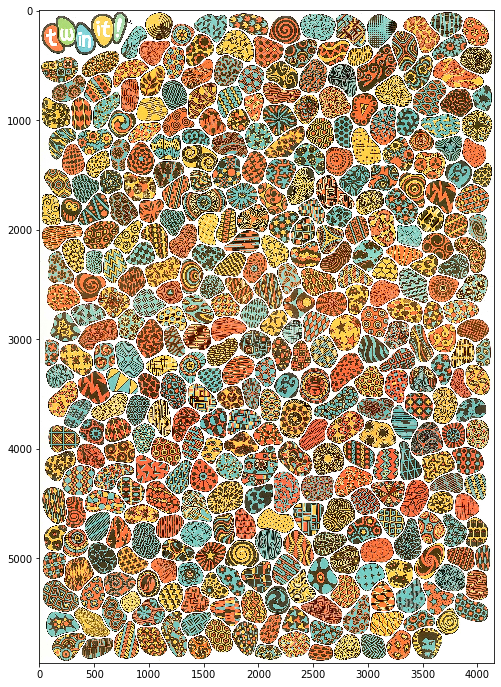

In [4]:
# TODO read and display image
from skimage import io
full_img = skimage.io.imread("img/twin_it/twin_it_200dpi.png")
plt.figure(figsize=(16, 12))
plt.imshow(full_img)
plt.show()

### Select some template
You can manually select a template using NumPy slicing, as you already know.

<div style="overflow: auto; border-style: dotted; border-width: 1px; padding: 10px; margin: 10px 0px">
<img alt="work" src='img/work.png' style='float: left; margin-right: 20px'>

**Select a pattern which looks like the following image.**
**Display it to control what you have just selected.**


<img alt="template" src='res/twin_it/bubbles_200dpi/b044.png' style='width: 200px'>

*Tip: You may want to crop a part **inside** the bubble for better results.*
</div>

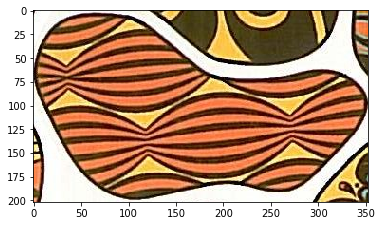

In [5]:
# TODO select a pattern to use as template and display it
pattern = full_img[658:860, 2040:2393]
plt.figure()
plt.imshow(pattern)
plt.show()

### Template matching
We will look for areas in the image which look like the current template.
As we previously said, we will use a very basic technique which is based on a simple difference computation: 
- for each possible position of the base image, we will try to match the template using a couple of variants, but the core idea is to compare pixel values,
- we can therefore compute a matching (dis)similarity for each position of the base image,
- if the method works well, then candidate matching areas should be located under and at the right of the positions where the (dis)similarity is either minimal or maximal (depending on what we compute).

We will use OpenCV [`matchTemplate()`](https://docs.opencv.org/4.1.0/df/dfb/group__imgproc__object.html) function because it provides more variants than the [`match_template()`](http://scikit-image.org/docs/stable/api/skimage.feature.html#skimage.feature.match_template) equivalent of scikit-image — which has a better padding management though…

You way want to have a look at those two tutorials:
- [OpenCV version](https://www.docs.opencv.org/2.4/doc/tutorials/imgproc/histograms/template_matching/template_matching.html)
- [scikit-image version](http://scikit-image.org/docs/stable/auto_examples/features_detection/plot_template.html)

The available methods for OpenCV's [`matchTemplate()`](https://docs.opencv.org/4.1.0/df/dfb/group__imgproc__object.html) are ($R$ is the result image, $I$ is the base image, $T$ is the template, and $(r,c)$ are coordinates):
- `cv2.TM_SQDIFF`: the sum of the squared differences between pixels values
$$R(r,c) = \sum\limits_{r',c'}(T(r',c') - I(r+r', c+c'))^2$$
- `cv2.TM_SQDIFF_NORMED`: the normalized sum of the squared difference between pixels 
$$R(r,c) = \frac{\sum\limits_{r',c'}(T(r',c') - I(r+r', c+c'))^2}{\sqrt{\sum\limits_{r',c'}(T(r',c'))^2 \cdot \sum\limits_{r',c'}I(r+r', c+c')^2}}$$
- `cv2.TM_CCORR`: the cross correlation between pixel values
$$R(r,c)= \sum _{r',c'} (T(r',c')  \cdot I(r+r',c+c'))$$
- `cv2.TM_CCORR_NORMED`: the normalized cross correlation between pixel values
$$R(r,c)= \frac{\sum_{r',c'} (T(r',c') \cdot I(r+r',c+c'))}{\sqrt{\sum_{r',c'}T(r',c')^2 \cdot \sum_{r',c'} I(r+r',c+c')^2}}$$
- `cv2.TM_CCOEFF`: the correlation coefficient between pixels values
$$R(r,c)= \sum _{r',c'} (T'(r',c') \cdot I'(r+r',c+c'))$$
where
$$\begin{array}{l} T'(r',c')=T(r',c') - 1/(w  \cdot h)  \cdot \sum _{r'',c''} T(r'',c'') \\ I'(r+r',c+c')=I(r+r',c+c') - 1/(w  \cdot h)  \cdot \sum _{r'',c''} I(r+r'',c+c'') \end{array}$$
- `cv2.TM_CCOEFF_NORMED`: the normalized correlation coefficient between pixels values
$$R(r,c)= \frac{ \sum_{r',c'} (T'(r',c') \cdot I'(r+r',c+c')) }{ \sqrt{\sum_{r',c'}T'(r',c')^2 \cdot \sum_{r',c'} I'(r+x',c+c')^2} }$$

We will briefly explain those equations during the session.

**For now, you just have to note two points.**
1. The resulting image has the same shape as the base image, and the value at each pixel indicates how well the template matches with the portion of the image covered when we "overlay" the pattern by aligning its upper-left corner with the current pixel.
2. For the squared difference, a lower value indicates a better match, but for the correlation-based ones its a higher value which indicates a better match.

Let us now compare these methods.

<div style="overflow: auto; border-style: dotted; border-width: 1px; padding: 10px; margin: 10px 0px">
<img alt="work" src='img/work.png' style='float: left; margin-right: 20px'>

**Compute and display the matching "maps" between the base image and the previously selected template, using each of those methods.**

</div>

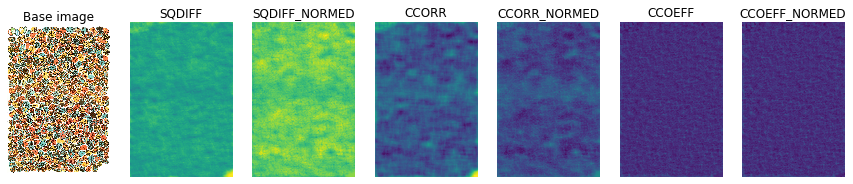

In [6]:
# TODO compute and display the matching "maps"
tm_methods = [
    (cv2.TM_SQDIFF, "SQDIFF"),
    (cv2.TM_SQDIFF_NORMED, "SQDIFF_NORMED"),
    (cv2.TM_CCORR, "CCORR"),
    (cv2.TM_CCORR_NORMED, "CCORR_NORMED"),
    (cv2.TM_CCOEFF, "CCOEFF"),
    (cv2.TM_CCOEFF_NORMED, "CCOEFF_NORMED")]
plt.figure(figsize=(15,15))
plt.subplot(1, 1+len(tm_methods), 1)
plt.imshow(full_img)
plt.axis("off")
plt.title("Base image")
for ii, (method, name) in enumerate(tm_methods):
    res = cv2.matchTemplate(full_img, pattern, method=method)  # FIXME use cv2.matchTemplate
    plt.subplot(1, 1+len(tm_methods), 2+ii)
    plt.imshow(res)
    plt.axis("off")
    plt.title(name)
plt.show()

### Display the best matches
We now need to locate area with the best match.
We can use two methods to get the coordinates of such pixel:
- with OpenCV we can use [`minMaxLoc()`](https://docs.opencv.org/4.1.0/d2/de8/group__core__array.html#gab473bf2eb6d14ff97e89b355dac20707) which returns `minVal, maxVal, minLoc, maxLoc`;
- with NumPy we can combine [`argmax`](https://docs.scipy.org/doc/numpy/reference/generated/numpy.argmax.html) or [`argmin`](https://docs.scipy.org/doc/numpy/reference/generated/numpy.argmin.html#numpy.argmin) (according to the method we use) and [`unravel_index`](https://docs.scipy.org/doc/numpy/reference/generated/numpy.unravel_index.html#numpy.unravel_index) which will convert the flat index return by `argxxx` into the appropriate value.

We will need to remove the region around the original patch to avoid find the exact same patch!

<div style="overflow: auto; border-style: dotted; border-width: 1px; padding: 10px; margin: 10px 0px">
<img alt="work" src='img/work.png' style='float: left; margin-right: 20px'>

**For each method display the matching area (cropped) in the original image and its position in the corresponding map, with and without removing the region around the original patch in the image.**
</div>

(2040, 658)
(2040, 658)
(3800, 5699)
(2040, 658)
(2040, 658)
(2040, 658)


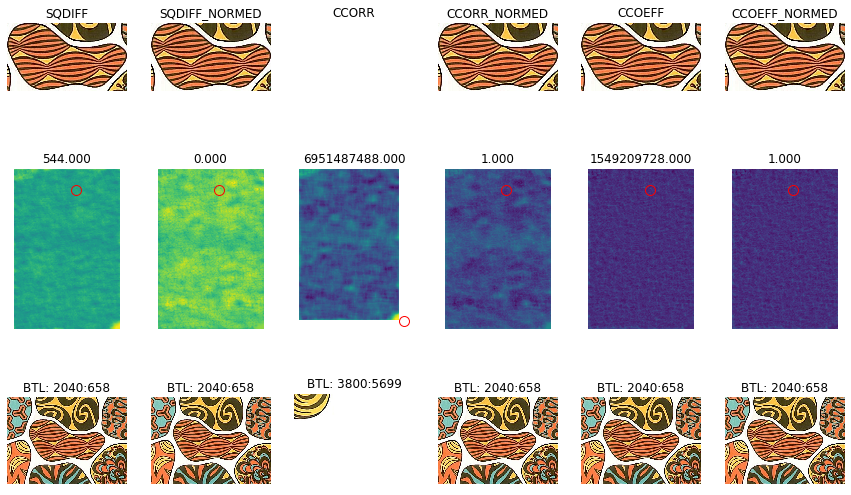

In [17]:
# TODO display cropped matches and position in maps

# change this to activate region removal
blank_patch_region = False
# coordinates of the area to erase
r_top = 658  # FIXME
c_left = 2040  # FIXME
r_bottom = 860  # FIXME
c_right = 2393  # FIXME

tm_methods = [
    # method, name, lower_is_better
    (cv2.TM_SQDIFF, "SQDIFF", True),
    (cv2.TM_SQDIFF_NORMED, "SQDIFF_NORMED", True),
    (cv2.TM_CCORR, "CCORR", False),
    (cv2.TM_CCORR_NORMED, "CCORR_NORMED", False),
    (cv2.TM_CCOEFF, "CCOEFF", False),
    (cv2.TM_CCOEFF_NORMED, "CCOEFF_NORMED", False)]

# Opt. blank the region around the original patch
full_img_2 = None
if blank_patch_region:
    #raise NotImplementedError("You still need to implement this!")
    # save the image!
    full_img_2 = full_img.copy() # TODO
    full_img_2[658:860, 2040:2393] = 0
    # erase the region
    # TODO
    # Display the original area, to control
    plt.figure()
    plt.imshow(full_img[658:860, 2040:2393])  # FIXME
    plt.title("Removed region")
    plt.show()
else:
    full_img_2 = full_img
    
plt.figure(figsize=(15,10))
for ii, (method, name, lower_is_better) in enumerate(tm_methods):
    # compute matching map
    res = cv2.matchTemplate(full_img_2, pattern, method=method)  # FIXME use cv2.matchTemplate
    # retrieve the location of the best value
    # FIXME use cv2.minMaxLoc
    minVal, maxVal, minLoc, maxLoc = cv2.minMaxLoc(res)
    if lower_is_better:
        bestVal = minVal
        bestLoc = minLoc
    else:
        bestVal = maxVal
        bestLoc = maxLoc
    # Display patch  
    ax = plt.subplot(3, len(tm_methods), 1+ii)
    bestLoc_c, bestLoc_r = bestLoc  # the order is reversed, this is terribly stupid
    endLoc_r, endLoc_c = np.array((bestLoc_r, bestLoc_c)) + pattern.shape[:2]
    patch = full_img[bestLoc_r:endLoc_r, bestLoc_c:endLoc_c, ...]
    plt.imshow(patch)
    plt.axis("off")
    plt.title(name)
    # Display region in map
    plt.subplot(3, len(tm_methods), 1+ii+len(tm_methods))
    plt.imshow(res)
    plt.plot((bestLoc_c+endLoc_c)//2, (bestLoc_r+endLoc_r)//2,
             'o', markeredgecolor='r', markerfacecolor='none', markersize=10)
    plt.axis("off")
    plt.title("%0.3f" % bestVal)
    # Display a zoomed-out region
    ax = plt.subplot(3, len(tm_methods), 1+ii+len(tm_methods)*2)
    zoom_margin = 100
    zoom = full_img[max(0, bestLoc_r-zoom_margin):min(endLoc_r+zoom_margin, full_img.shape[0]),
                    max(0, bestLoc_c-zoom_margin):min(endLoc_c+zoom_margin, full_img.shape[1]),
                    ...]
    plt.imshow(zoom)
    plt.axis("off")
    plt.title("BTL: %d:%d" % bestLoc) # BTL = Best Top Left
plt.show()

## Time to step back
OK, we have started to work on something.
We are the point where we may have ideas about things to try: use grayscale images instead of color images, iterate over the best matches to look for a relevant match, suppress local maximums close to another local maximum…

**But wait.**

First, let us "save" where we are.

<div style="overflow: auto; border-style: dotted; border-width: 1px; padding: 10px; margin: 10px 0px">
<img alt="work" src='img/work.png' style='float: left; margin-right: 20px'>

**Write down some notes summarizing your first observations: What have you done? What were the results you expected? Did you results you obtained match you expectations?**

*Note: It is very important to force yourself to keep a journal of your experiments.*
</div>

Write somes notes here.

### Criticize the approach
Now we have kept track of what we are doing, we can try to think a bit more about what we are actually doing.

<div style="overflow: auto; border-style: dotted; border-width: 1px; padding: 10px; margin: 10px 0px">
<img alt="work" src='img/work.png' style='float: left; margin-right: 20px'>

**Write down some critics about our approach: How confident can we be about the results we obtained? Can we draw some solid conclusions about the performance of the methods we are comparing?**

*Note: The worst bias in Machine Learning is the designer's optimism. We all want our method to perform well and would be tempted to stop at the first promising results, reporting good news to a customer: "It works!". This is a terrible trap.*
</div>

Write some critics here.

## A sound(er) approach
We will now set up an experimental setup which will be useful for the next session.

### Experiment-driven research

This is what you should always do first, to perform **experiment-driven research** — much alike test-driven development: 
1. define the task in a testable way,
2. ensure you have some data and associated ground truth,
3. implement the evaluation framework.

To complete this session, we will now start over and make sure we have all the necessary pre-requisites to perform sound experiments.

To facilitate your work, we already segmented all the bubbles and gave them an id. If we have time, we'll discuss how we did that and/or show you the code (in two words: simple thresholding and two connected components labellings). You can now use images likes those:

<img alt="b002" src='img/twin_it/bubbles_200dpi/b002.png' style='height: 100px; float: left; margin-right: 20px'>
<img alt="b003" src='img/twin_it/bubbles_200dpi/b003.png' style='height: 100px; float: left; margin-right: 20px'>
<img alt="b004" src='img/twin_it/bubbles_200dpi/b004.png' style='height: 100px; float: left; margin-right: 20px'>
<img alt="b005" src='img/twin_it/bubbles_200dpi/b005.png' style='height: 100px; float: left; margin-right: 20px'>
<img alt="b006" src='img/twin_it/bubbles_200dpi/b006.png' style='height: 100px; float: left; margin-right: 20px'>
<div style='clear: both'></div>

All the files are located here: `twin_it/bubbles_200dpi/bNNN.png` where `NNN` is a zero-padded number between `001` and `391`.

We will also help you by telling you that those two bubbles (`b044` and `b092`) have twins (there are more twins though!):

<img alt="b044" src='img/twin_it/bubbles_200dpi/b044.png' style='height: 150px; float: left; margin-right: 20px'>
<img alt="b092" src='img/twin_it/bubbles_200dpi/b092.png' style='height: 150px; float: left; margin-right: 20px'>
<div style='clear: both'></div>


and that those two bubbles (`b001` and `b096`) do **not** have twins:

<img alt="b001" src='img/twin_it/bubbles_200dpi/b001.png' style='height: 150px; float: left; margin-right: 20px'>
<img alt="b096" src='img/twin_it/bubbles_200dpi/b096.png' style='height: 150px; float: left; margin-right: 20px'>
<div style='clear: both'></div>

You will now try to match pairs of isolated bubbles. This removes the risk of matching in-between content and allows us to have a precise and simple evaluation: for a given test bubble, we should know what is the twin bubble, if there is any.

### Image borders and padding
You will need a little trick to be able to perform pattern matching on images which have approximately the same size: you will have to pad the base image (one of the two bubble being matched) in order to cope with possible texture translation. You can use the function [`cv2.copyMakeBorder()`](https://docs.opencv.org/4.1.0/d2/de8/group__core__array.html#ga2ac1049c2c3dd25c2b41bffe17658a36).
The goal is to ensure that the base image has borders large enough to contain the largest patterns (both horizontally and vertically).

As image border is an important concept, we will illustrate the possible borders values before going further.
This section is copied from the [original OpenCV documentation](https://docs.opencv.org/4.1.0/d3/df2/tutorial_py_basic_ops.html).

The function `cv2.copyMakeBorder()` takes following arguments:
- `src`: input image
- `top`, `bottom`, `left`, `right`: border width in number of pixels in corresponding directions
- `borderType`: Flag defining what kind of border to be added. It can be following types:
   - `cv2.BORDER_CONSTANT`: Adds a constant colored border, like this: `xxxxx|abcdefgh|xxxxx`. The value should be given as next argument.
   - `cv2.BORDER_REFLECT`: Border will be mirror reflection of the border elements, like this: `fedcba|abcdefgh|hgfedcb`
   - `cv2.BORDER_REFLECT_101` or `cv.BORDER_DEFAULT`: Same as above, but with a slight change, like this: `gfedcb|abcdefgh|gfedcba`
   - `cv2.BORDER_REPLICATE`: Last element is replicated throughout, like this: `aaaaaa|abcdefgh|hhhhhhh`
   - `cv2.BORDER_WRAP`: Circular copy of the rows and columns from the other side of the image, like this: `cdefgh|abcdefgh|abcdefg`
- `value` - Color of border if border type is `cv2.BORDER_CONSTANT`

Below is a sample code demonstrating all these border types for better understanding:
```python
import cv2
import numpy as np
from matplotlib import pyplot as plt
BLUE = [255,0,0]
img1 = cv2.imread('opencv-logo.png')
replicate = cv2.copyMakeBorder(img1,10,10,10,10,cv2.BORDER_REPLICATE)
reflect = cv2.copyMakeBorder(img1,10,10,10,10,cv2.BORDER_REFLECT)
reflect101 = cv2.copyMakeBorder(img1,10,10,10,10,cv2.BORDER_REFLECT_101)
wrap = cv2.copyMakeBorder(img1,10,10,10,10,cv2.BORDER_WRAP)
constant= cv2.copyMakeBorder(img1,10,10,10,10,cv2.BORDER_CONSTANT,value=BLUE)
plt.subplot(231),plt.imshow(img1,'gray'),plt.title('ORIGINAL')
plt.subplot(232),plt.imshow(replicate,'gray'),plt.title('REPLICATE')
plt.subplot(233),plt.imshow(reflect,'gray'),plt.title('REFLECT')
plt.subplot(234),plt.imshow(reflect101,'gray'),plt.title('REFLECT_101')
plt.subplot(235),plt.imshow(wrap,'gray'),plt.title('WRAP')
plt.subplot(236),plt.imshow(constant,'gray'),plt.title('CONSTANT')
plt.show()
```
This produces the result below. (Image is displayed with matplotlib. So RED and BLUE channels will be interchanged):
![Borders](img/practice_01/ocv_borders.jpg)


### Read all the bubble images
We can make use of Jupyter's magic to quickly get a list of all bubble images, and load them all.

<div style="overflow: auto; border-style: dotted; border-width: 1px; padding: 10px; margin: 10px 0px">
<img alt="work" src='img/work.png' style='float: left; margin-right: 20px'>

**Read all bubble images. They are located under `twin_it/bubbles_200dpi/b???.png`. You may want to resize them using `cv2.resize()`.**
</div>

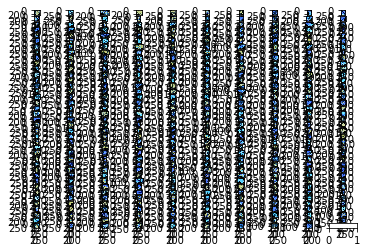

In [22]:
# TODO read bubble images
import glob

bubble_files = [cv2.imread(file) for file in glob.glob("img/twin_it/bubbles_200dpi/b*.png")]
plt.figure()
for bf, i in zip(bubble_files, range(len(bubble_files) - 1)):
    plt.imshow(bf)
    plt.subplot(39, 10, i + 1)
plt.show()  # FIXME

### Prepare the test images
It is more efficient to consider the bubble under test as the base image, and pad it once for all.

<div style="overflow: auto; border-style: dotted; border-width: 1px; padding: 10px; margin: 10px 0px">
<img alt="work" src='img/work.png' style='float: left; margin-right: 20px'>

**Identity the test images (declare a separate list) and prepare them.**

*Hint: compute the largest height and width for the bubbles to pad the images.*
</div>

In [ ]:
# TODO identify the test images
test_image_ids_withtwin = bubble_files[[43, 91]]  # FIXME
test_image_ids_notwin = bub[[0, 95]]  # FIXME
plt.figure()
for ii, img_id in enumerate(test_image_ids_withtwin + test_image_ids_notwin):
    plt.subplot(1, 4, 1+ii)
    plt.imshow(cv2.cvtColor(bubble_images[img_id], cv2.COLOR_BGR2RGB))
    plt.title(bubble_files[img_id].split('/')[-1])
    plt.axis('off')
plt.show()

max_bubble_shape = None  # FIXME


test_image_withtwin = []  # FIXME
test_image_notwin = []  # FIXME
plt.figure(figsize=(16, 16))
for ii, img in enumerate(test_image_withtwin + test_image_notwin):
    plt.subplot(1, 4, 1+ii)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
plt.show()

### Match test bubbles against the others
We can now compute the matching of each bubble against the others, with the method of our choice.

<div style="overflow: auto; border-style: dotted; border-width: 1px; padding: 10px; margin: 10px 0px">
<img alt="work" src='img/work.png' style='float: left; margin-right: 20px'>

**For all the methods, for all 4 test images, compute the matching distance or score and display the query along with the 5 best matches and their associated values.**

*Optional: Skip the bubble with the same id.*

*Hint: Use `np.argsort` to get the ids of the best matches.*

*Hint2: Crop the template to keep its central area and remove most of black surroundings (this yields better results).*
</div>

<div style="overflow: auto; border-style: dotted; border-width: 1px; padding: 10px; margin: 10px 0px">
<img alt="work" src='img/help.png' style='float: left; margin-right: 20px'>
    
If you do not manage to perform those computations, or if you have time to take a broader look at the results, you can still inspect the file `twin_it/dist_mat_sqdiff_normed.npz` to get the (triangular) matrix of squared differences between **all** patches.
</div>

In [ ]:
# TODO find the best matches for all test images


### Analyze the results
We now have enough information to draw some conclusions about this approach.

<div style="overflow: auto; border-style: dotted; border-width: 1px; padding: 10px; margin: 10px 0px">
<img alt="work" src='img/work.png' style='float: left; margin-right: 20px'>

**Conclude this first session by writin down some quick answers to the following quetions:**
- **Can we draw conclusions about the performance of each method?**
- **Can we be confident about the results we obtain?**
- **Are there interesting phenomemons in the results?**
- **It is still possible to solve the current problem?**
- **What are the limits of our approach?**
</div>

TODO write your answers here

# Job done!
Congratulations, you just reached the end of this session!